In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os
import pandas as pd
import matplotlib as mpl
import sys
import cmasher as cmr
from scipy.spatial import distance_matrix
import logging
from collections import namedtuple
from datetime import datetime

# Add additional paths for custom modules
sys.path.insert(0, '/fred/oz381/cpower/analysistools')
import merger_tree_tools as mtt
import snapshot_tools as st
import halo_tools as ht
import galaxy_tools as gt
import analysis_tools as at

plt.style.use('/home/aussing/sty.mplstyle')
cmap = cmr.torch
# plt.rcParams['text.usetex'] = True
# plt.rcParams['font.size'] = 14

LITTLEH    = 0.6688
UNITMASS   = 1.0e10
GASTYPE    = 0
HIGHDMTYPE = 1
STARTYPE   = 4
LOWDMTYPE  = 5



In [2]:
def get_sim_data(sim_directory,i_file):
    snap_fname     = f'/snapshot_{str(i_file).zfill(3)}.hdf5'
    snap_directory = sim_directory + snap_fname
    snap_data     = h5py.File(snap_directory, 'r')
    
    # haloinfo_fname     = f'/fof_tab_{str(i_file).zfill(3)}.hdf5'
    haloinfo_fname     = f'/fof_subhalo_tab_{str(i_file).zfill(3)}.hdf5'
    haloinfo_directory = sim_directory + haloinfo_fname
    haloinfo_data = h5py.File(haloinfo_directory, 'r')

    z = (snap_data['Header'].attrs['Redshift'])
    # print(z)
    return snap_data, haloinfo_data, z

In [3]:
def analytic_SMHM():
    from halotools.empirical_models import PrebuiltSubhaloModelFactory
    model = PrebuiltSubhaloModelFactory('behroozi10',redshift=0)
    halo_mass = np.logspace(11.8, 12.8, 100)
    # halo_mass = np.logspace(10, 14, 100)
    mean_sm = model.mean_stellar_mass(prim_haloprop = halo_mass)
    return halo_mass, mean_sm
    

In [4]:
def MWA_stellar_halo_mass(sim_directory,i_file):
    snap_data, haloinfo_data, z = get_sim_data(sim_directory,i_file)
    halo_M200c     = np.array(haloinfo_data['Group']['Group_M_Crit200'], dtype=np.float64) * UNITMASS / LITTLEH
    halo_masstypes = np.array(haloinfo_data['Group']['GroupMassType'], dtype=np.float64) * UNITMASS / LITTLEH 
    
    mass_mask = np.argsort(halo_M200c)[::-1]
    halo_mainID = np.where(halo_masstypes[mass_mask,LOWDMTYPE] == 0)[0][0]
    
    return halo_M200c[mass_mask[halo_mainID]], halo_masstypes[mass_mask[halo_mainID],4]

In [5]:
def stellar_mass_halo_mass(sim_directory,label,color,i_file):
        # print('\n',label)
        snap_data, haloinfo_data, z = get_sim_data(sim_directory,i_file)

        halo_mass  = np.array(haloinfo_data['Group']['GroupMass'], dtype=np.float64) * UNITMASS / LITTLEH
        halo_M200c = np.array(haloinfo_data['Group']['Group_M_Crit200'], dtype=np.float64) * UNITMASS / LITTLEH
        halo_masstypes = np.array(haloinfo_data['Group']['GroupMassType'], dtype=np.float64) * UNITMASS / LITTLEH

        # print(halo_masstypes)
        clean_haloes = np.where(halo_masstypes[:,5]==0)[0]

        plt.scatter(halo_M200c[clean_haloes],halo_masstypes[clean_haloes,4],label=label,color=color)

In [6]:
i_file = 26
analytic_halo_mass, analytic_mean_sm = analytic_SMHM()

folder_list = []
for simulation_name in [ simulation_name for simulation_name in os.listdir('/fred/oz217/aussing/') if ( simulation_name.startswith("N2048_L65_sd") )]:
    folder_list.append(simulation_name)
folder_list = np.sort(folder_list)
print(folder_list)

['N2048_L65_sd00372' 'N2048_L65_sd01829' 'N2048_L65_sd02640'
 'N2048_L65_sd03157' 'N2048_L65_sd04721' 'N2048_L65_sd05839'
 'N2048_L65_sd06382' 'N2048_L65_sd07409' 'N2048_L65_sd08230'
 'N2048_L65_sd09675' 'N2048_L65_sd17492' 'N2048_L65_sd28504'
 'N2048_L65_sd34920' 'N2048_L65_sd46371' 'N2048_L65_sd57839'
 'N2048_L65_sd61284' 'N2048_L65_sd70562' 'N2048_L65_sd80325'
 'N2048_L65_sd93745']


Missing files in N2048_L65_sd07409


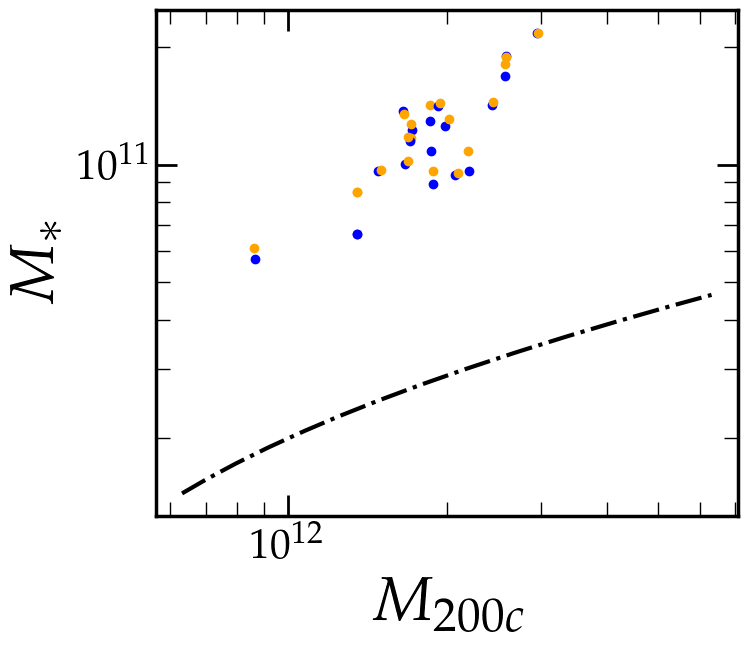

In [8]:
fig=plt.subplots(figsize=(8,7))

for folder in folder_list:
        # print(folder)
        cdm_file_loc = f'/fred/oz217/aussing/{folder}/cdm/zoom/output/sn_010/'
        wdm_file_loc = f'/fred/oz217/aussing/{folder}/wdm_3.5/zoom/output/sn_005/'
        # stellar_mass_halo_mass(cdm_file_loc,'','blue',26)
        # stellar_mass_halo_mass(wdm_file_loc,'','orange',26)
        try:
                CDM_halo_mass, CDM_stellar_mass = MWA_stellar_halo_mass(cdm_file_loc,i_file)
                WDM_halo_mass, WDM_stellar_mass = MWA_stellar_halo_mass(wdm_file_loc,i_file)
        except:
                print(f'Missing files in {folder}')

        plt.scatter(CDM_halo_mass,CDM_stellar_mass,c='blue')
        plt.scatter(WDM_halo_mass,WDM_stellar_mass,c='orange')

plt.plot(analytic_halo_mass,analytic_mean_sm, label="Behroozi 2010",color='k', ls='-.')
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'$M_{200c}$')
plt.ylabel(r'$M_{*}$')
plt.tight_layout()